# **<font color='violet'>Cluster analysis of Corpora Amylacea Morphology in Alzheimers Disease and Healthy Controls</font>**
## IDSC Fellows Symposium
### *Julian Dallmeier*
__________________________________________________________________________________________________________________________

# **<font color='violet'>Research Question:</font>**
# *Do Corpora Amylacea size, shape, and location influence Alzheimers Disease diagnosis?*
__________________________________________________________________________________________________________________________

# **<font color='violet'>Background:</font>**
### - Alzheimers Disease (AD) clinical presentation is strongly associated with tau burden
### - Corpora Amylacea (CA) are vessicles that clean up cellular waste, they are essentially trash cans  
### - CA are thought to clean up tau
### - APOE4 is the strongest associated risk allele
### - We wanted to carry out a detailed characterization and exploratory analysis of CA in AD and Control brains
__________________________________________________________________________________________________________________________

# **<font color='violet'>Dataset:</font>**
## Morphological and spatial metrics from 2,989 Corpora Amylacea were extracted from human post-mortem tissue samples from 9 AD cases and 4 Controls.
#### Tissue was sectioned, stained (PAS: periodic acid schiff), and digitized for analysis
## The following features of individual Corpora Amylacea were measured:
#### - Area: πr^2 (Bigger = more "trash"?)
#### - Circularity: 4π*area/perimeter^2 
#### - Nearest neightbor distance: distance to nearest CA
#### - Percent area occupied: sum(CA area)/total area * 100
__________________________________________________________________________________________________________________________

## Import Packages

In [ ]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import umap
import umap.plot
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.neural_network import MLPClassifier
import numpy as np
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

## Preprocessing

In [ ]:
df2 = pd.read_csv('data/cell_morphologies.csv')
apoe = LabelEncoder()
apoe.fit(df2['APOE'])
apoe = apoe.transform(df2['APOE'])
df2['APOE_'] = apoe
df2 = df2.drop(['X', 'Y', 'APOE', 'ROI_area'], axis=1)
df2_ = df2.drop(['subject','CA_mm2','region','CellNumber','APOE_'], axis =1)
df1 = pd.read_csv('data/demographics.csv')
df2 = df2.merge(df1, how='inner', on='subject')

## Unsupervised Learning with UMAP 
#### - UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction
#### - UMAP is a nonlinear dimensionality reduction technique
#### - We decided to use CA as the unit of measurement 

In [ ]:
reducer = umap.UMAP()
df3 = df2[["Area",
        "Circ.",
        "NND", "%AO"]].values
df3_ = StandardScaler().fit_transform(df3)
embedding = reducer.fit_transform(df3_)
mapper = umap.UMAP().fit(df3_.data)
hover_data = df2

In [ ]:
umap.plot.points(mapper, labels=df2.Diagnosis_y, theme='fire')

In [ ]:
umap.plot.points(mapper, labels=df2.region, theme='fire')

In [ ]:
umap.plot.points(mapper, labels=df2.APOE_, theme='fire')

In [ ]:
umap.plot.points(mapper, labels=df2.B_Score, theme='fire')

__________________________________________________________________________________________________________________________
# **<font color='violet'>Conclusions:</font>**
## - CA in the CA 3 region of AD patients appear to be different with respect to size/shape/NND/%AO 
__________________________________________________________________________________________________________________________

## Step 5. Supervised Learning 
#### - Metrics include, Area, Circularity, NND, %AO
_________

### KNN Algorithm

In [ ]:
#Modeling
diag = LabelEncoder()
diag.fit(df2['Diagnosis_y'])
diag = diag.transform(df2['Diagnosis_y'])

y = diag
X = df2[['Area', 'NND', 'Circ.', '%AO']]

#KNN CLASSIFICATION MODEL
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10)
KNN_model = KNeighborsClassifier(n_neighbors=10)
KNN_model.fit(X_train, y_train)
KNN_prediction = KNN_model.predict(X_test)

# Accuracy score is the simplest way to evaluate
print('Accuracy score: ',accuracy_score(KNN_prediction, y_test))

________________________
### Logistic Regression

In [ ]:
# Logistic regression
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(random_state=None).fit(X_train, y_train)
lr_pre = LR.predict(X_test) #Return the predictions
print('Accuracy score: ',accuracy_score(lr_pre, y_test)) #Return the mean accuracy on the given test data and labels

In [ ]:
coef_table = pd.DataFrame(list(X_train.columns)).copy()
coef_table.insert(len(coef_table.columns),"Coefs",LR.coef_.transpose())
coef_table.sort_values(by=['Coefs'], ascending = True)

______________________________________________
### Random forest

In [ ]:
rf = RandomForestClassifier(max_depth=2, random_state=None)
rf.fit(X, y)
rf_predict = rf.predict(X_test)
print('Accuracy score: ',accuracy_score(rf_predict, y_test))

In [ ]:
#Feature importance based on mean decrease in impurity
import time
start_time = time.time()
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

In [ ]:
feature_names2 = ['Area', 'NND', 'Circ.', '%AO']
forest_importances = pd.Series(importances, index=feature_names2)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

### Dummy Classifier 

In [ ]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X, y)
DummyClassifier(strategy='most_frequent')
dummy_clf.predict(X)
dummy_clf.score(X, y)

### ROC Curve for our Models

In [ ]:
from sklearn.metrics import plot_roc_curve
fig, ax = plt.subplots(figsize=(12, 12))
rf_disp = plot_roc_curve(rf, X_test, y_test, ax=ax)
knn_disp = plot_roc_curve(KNN_model, X_test, y_test, ax=ax)
log_disp = plot_roc_curve(LR, X_test, y_test, ax=ax)
dummy_disp = plot_roc_curve(dummy_clf, X_test, y_test, ax=ax)

__________________________________________________________________________________________________________________________
# **<font color='violet'>Conclusions:</font>**
## - %AO and Circularity are the heaviest weighted features in our model, suggesting the strongest associations with AD status
## - These analysis have deepened my understanding of Corpora Amylacea and led to novel ideas which will be implemented into my thesis project
## - We plan to scale up this analysis in a larger dataset of 60+ brains (~12,000 cells)
__________________________________________________________________________________________________________________________

# Thank you to the IDSC and my mentors Dr. Ogihara, Dr. Scott, and Jerry Bonnell 
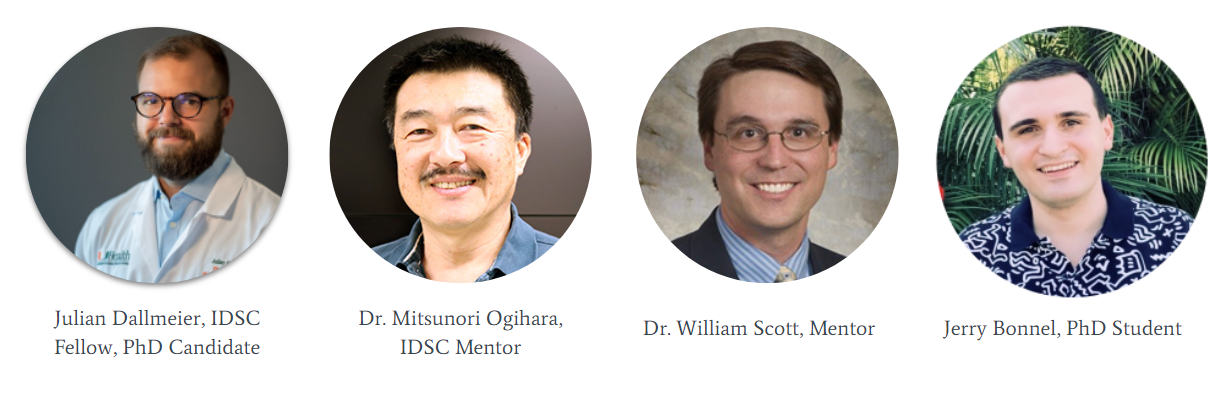